Notebook which produces data required for figure 6. Executes a CIFAR network temporally.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as be

In [3]:
from utils import *
from data import *
from layers import *
from models import *

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
# Currently the eager execution mode in dynamic inference leads to GPU memory usage increasing over time. 
# GPU acceleration does not help accelerate the dynamic inference by much so it should be disabled during the
# long inference over 1024 examples to prevent out-of-memory errors on GPU. 

limit_gpus()
set_gpu(None)

In [6]:
dataset = "cifar10"
n_batch = 128
ds_train, ds_test, ds_info = load_dataset(dataset, n_batch)

input_shape = ds_info.features['image'].shape
num_classes = ds_info.features['label'].num_classes

In [7]:
input_shape

(32, 32, 3)

In [8]:
m_repeats = 15

In [8]:
x_train, y_train = get_raw_dat(ds_train)
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [14]:
model = Conv2DPhasorModel(input_shape, projection="dot", onehot_offset=0.0, 
                    onehot_phase=0.5,n_hidden=1000, dropout_rate=0.20,
                         repeats=m_repeats,
                         exec_time=20.0)

In [13]:
model.dyn_params

{'leakage': -0.2,
 'period': 1.0,
 'window': 0.05,
 'spk_mode': 'gradient',
 'threshold': 0.03,
 'exec_time': 16.0,
 'max_step': 0.02}

In [14]:
model.compile(optimizer="rmsprop")

In [15]:
#train the model with the augmented dataset or load the pre-trained model (below)
#loss = model.train_aug(datagen.flow(x_train, y_train, batch_size=128), 76000)

In [28]:
model.load_weights("models/cifar1.wg")
model.direction = tf.constant(np.load("models/cifar_projection.npz")["a"])

In [29]:
(xs, ys) = next(iter(ds_train))

In [30]:
model(xs)

<tf.Tensor: shape=(128, 10), dtype=float32, numpy=
array([[ 3.89004052e-02, -1.26685705e-02,  5.19245744e-01, ...,
        -2.35516988e-02,  1.00711109e-02,  2.70870589e-02],
       [-4.48176106e-05,  2.05502938e-02,  5.89586645e-02, ...,
         2.52582163e-01, -8.37364048e-03,  3.74316685e-02],
       [-1.59444381e-02,  1.60924550e-02,  1.96316130e-02, ...,
        -9.08434112e-03,  5.67700621e-03,  1.91085041e-02],
       ...,
       [-6.71685934e-02,  2.95092072e-02,  2.89912615e-02, ...,
         4.17948723e-01, -1.16594173e-02, -4.92377803e-02],
       [-1.68786701e-02,  1.31507501e-01, -2.57096589e-02, ...,
        -2.82513928e-02,  2.62692291e-03,  1.67635754e-01],
       [-7.57708447e-03,  3.94355595e-01, -9.74254869e-03, ...,
        -1.94729734e-02,  1.08415276e-01,  4.00708281e-02]], dtype=float32)>

In [16]:
model.accuracy(ds_test, False)

(<tf.Tensor: shape=(), dtype=float64, numpy=0.702>,)

In [16]:
# dynamic call

In [ ]:
n_batches = 8

In [15]:
n_subsample = n_batch * n_batches

In [16]:
n_subsample

1024

In [17]:
x_test, y_test = get_raw_dat(ds_test)

In [ ]:
# save each batch's output as it is computed
# dynamic execution with the CIFAR network takes several hours per batch

In [24]:
for i in range(n_batches):
    i_start = i * n_batch
    i_stop = (i+1) * n_batch
    print("starting batch " + str(i))
    
    test_subset = tf.data.Dataset.from_tensor_slices((x_test[i_start:i_stop, ...], y_test[i_start:i_stop, ...]))
    test_subset = test_subset.batch(n_batch)
    
    dyn_y = model.evaluate(test_subset, method="dynamic")
    
    filename = "cifar_dyn_batch"+str(i)+(".npz")
    np.savez_compressed(filename, a=dyn_y.numpy())
    

starting batch 0


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Conv 1


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Conv 2


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Dense


100%|██████████| 128/128 [08:26<00:00,  3.96s/it]


starting batch 1


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Conv 1


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Conv 2


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Dense


100%|██████████| 128/128 [08:17<00:00,  3.88s/it]


starting batch 2


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Conv 1


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Conv 2


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Dense


100%|██████████| 128/128 [08:18<00:00,  3.89s/it]


starting batch 3


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Conv 1


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Conv 2


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Dense


100%|██████████| 128/128 [08:24<00:00,  3.94s/it]


starting batch 4


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Conv 1


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Conv 2


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Dense


100%|██████████| 128/128 [08:23<00:00,  3.93s/it]


starting batch 5


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Conv 1


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Conv 2


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Dense


100%|██████████| 128/128 [08:15<00:00,  3.87s/it]


starting batch 6


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Conv 1


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Conv 2


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Dense


100%|██████████| 128/128 [08:20<00:00,  3.91s/it]


starting batch 7


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Conv 1


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Conv 2


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Dense


100%|██████████| 128/128 [08:22<00:00,  3.93s/it]


In [25]:
trueys = y_test[0:n_subsample,...]

In [26]:
np.savez_compressed("matching_ys.npz", a = trueys)

In [ ]:
#run from saved results (can resume from here when results are saved)

In [9]:
trueys = np.load("matching_ys.npz")['a']

In [10]:
all_res = [np.load("cifar_dyn_batch"+str(i)+".npz")["a"] for i in range(8)]

In [11]:
dyn_yhs0 = tf.concat(all_res, axis=0)

In [15]:
dyn_yhs = model.predict(dyn_yhs0, method="dynamic")

In [16]:
trueys

array([6, 7, 6, ..., 1, 1, 8])

In [18]:
dyn_yhs == trueys

array([False,  True,  True, ...,  True,  True,  True])

In [20]:
all_predictions = np.array([np.mean(model._predict_ind(dyn_yhs0, i) == trueys) for i in range(m_repeats)])

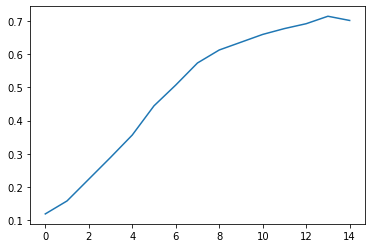

In [21]:
plt.plot(all_predictions)

In [25]:
np.savez_compressed("1024_dyn.npz", a=all_predictions)

In [45]:
test_x, test_y = get_raw_dat(ds_test)

In [46]:
first_1024x = test_x[0:1024,...]
first_1024y = test_y[0:1024,...]

In [38]:
stat_y = model.call(first_1024x)

In [40]:
statys = model.predict(stat_y)

In [ ]:
#the dynamic CIFAR accuracy

In [41]:
dyn_a = np.mean(dyn_yhs == trueys)

In [42]:
statys

<tf.Tensor: shape=(1024,), dtype=int64, numpy=array([7, 1, 6, ..., 3, 4, 6])>

In [47]:
stat_a = tf.reduce_mean(tf.cast(statys == first_1024y, dtype="float"))

In [ ]:
#the static CIFAR accuracy

In [48]:
stat_a

<tf.Tensor: shape=(), dtype=float32, numpy=0.7314453>

In [ ]:
#the accuracy loss

In [49]:
stat_a - dyn_a

<tf.Tensor: shape=(), dtype=float32, numpy=0.017578125>